In [1]:
!pip install -q kaggle



In [2]:
# Move kaggle.json to the appropriate location
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [4]:
!kaggle datasets download -d tongpython/cat-and-dog


Dataset URL: https://www.kaggle.com/datasets/tongpython/cat-and-dog
License(s): CC0-1.0
 99% 215M/218M [00:05<00:00, 45.2MB/s]
100% 218M/218M [00:05<00:00, 38.3MB/s]


In [5]:
!unzip cat-and-dog.zip -d ./cat-and-dog


Streaming output truncated to the last 5000 lines.
  inflating: ./cat-and-dog/training_set/training_set/cats/cat.3704.jpg  
  inflating: ./cat-and-dog/training_set/training_set/cats/cat.3705.jpg  
  inflating: ./cat-and-dog/training_set/training_set/cats/cat.3706.jpg  
  inflating: ./cat-and-dog/training_set/training_set/cats/cat.3707.jpg  
  inflating: ./cat-and-dog/training_set/training_set/cats/cat.3708.jpg  
  inflating: ./cat-and-dog/training_set/training_set/cats/cat.3709.jpg  
  inflating: ./cat-and-dog/training_set/training_set/cats/cat.371.jpg  
  inflating: ./cat-and-dog/training_set/training_set/cats/cat.3710.jpg  
  inflating: ./cat-and-dog/training_set/training_set/cats/cat.3711.jpg  
  inflating: ./cat-and-dog/training_set/training_set/cats/cat.3712.jpg  
  inflating: ./cat-and-dog/training_set/training_set/cats/cat.3713.jpg  
  inflating: ./cat-and-dog/training_set/training_set/cats/cat.3714.jpg  
  inflating: ./cat-and-dog/training_set/training_set/cats/cat.3715.jpg  
 

In [11]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Dataset directory
data_dir = "./cat-and-dog"

# Image dimensions and batch size
IMG_SIZE = (150, 150)
BATCH_SIZE = 32

# Data generator for training and validation
datagen = ImageDataGenerator(rescale=1.0/255.0, validation_split=0.2)

# Training dataset
train_data = datagen.flow_from_directory(
    data_dir,                # Correct path to the dataset directory
    target_size=IMG_SIZE,    # Resizing images to IMG_SIZE
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'        # Indicates training subset
)

# Validation dataset
val_data = datagen.flow_from_directory(
    data_dir,                # Correct path to the dataset directory
    target_size=IMG_SIZE,    # Resizing images to IMG_SIZE
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'      # Indicates validation subset
)

# Testing dataset
test_data_gen = ImageDataGenerator(rescale=1.0/255.0)  # Separate generator for test set

test_data = test_data_gen.flow_from_directory(
    data_dir,                # Correct path to the dataset directory
    target_size=IMG_SIZE,    # Resizing images to IMG_SIZE
    batch_size=BATCH_SIZE,
    class_mode='categorical' # Class mode should match your model output
)


Found 8023 images belonging to 2 classes.
Found 2005 images belonging to 2 classes.
Found 10028 images belonging to 2 classes.


In [12]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

In [17]:

from tensorflow.keras.regularizers import l2

# Pretrained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))

# Freeze the base model to retain pretrained weights
base_model.trainable = False

# Apply L2 regularization with a factor of 0.01
regularization_factor = 0.01

# Build the full model
model = Sequential([
    base_model,                               # Pretrained ResNet50 as base
    GlobalAveragePooling2D(),                 # Pooling layer
    Dense(256, activation='relu',
          kernel_regularizer=l2(regularization_factor)),  # Fully connected layer with L2
    Dense(train_data.num_classes, activation='softmax',
          kernel_regularizer=l2(regularization_factor))   # Output layer with L2
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model summary
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 5, 5, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,112,770 (91.98 MB)

 Trainable params: 525,058 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [18]:
# Train the model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,  # Adjust epochs as needed
    steps_per_epoch=50,
    validation_steps=50
)

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 295s 6s/step - accuracy: 0.7948 - loss: 3.1167 - val_accuracy: 0.8012 - val_loss: 0.6831
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 181s 4s/step - accuracy: 0.7869 - loss: 0.6399 - val_accuracy: 0.7802 - val_loss: 0.6013
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 293s 6s/step - accuracy: 0.7790 - loss: 0.6055 - val_accuracy: 0.7969 - val_loss: 0.5733
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 234s 5s/step - accuracy: 0.7901 - loss: 0.5633 - val_accuracy: 0.8272 - val_loss: 0.5061
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 285s 6s/step - accuracy: 0.7775 - loss: 0.5735 - val_accuracy: 0.7900 - val_loss: 0.5907
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 39s 749ms/step - accuracy: 0.7812 - loss: 0.6119 - val_accuracy: 0.8148 - val_loss: 0.5239
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 287s 6s/step - accuracy: 0.7887 - loss: 0.5697 - val_accuracy: 0.7950 - val_loss: 0.5367
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 239s 5s/step - accuracy: 0.8108 - loss: 0.5196 - val_accuracy: 0.7802 -

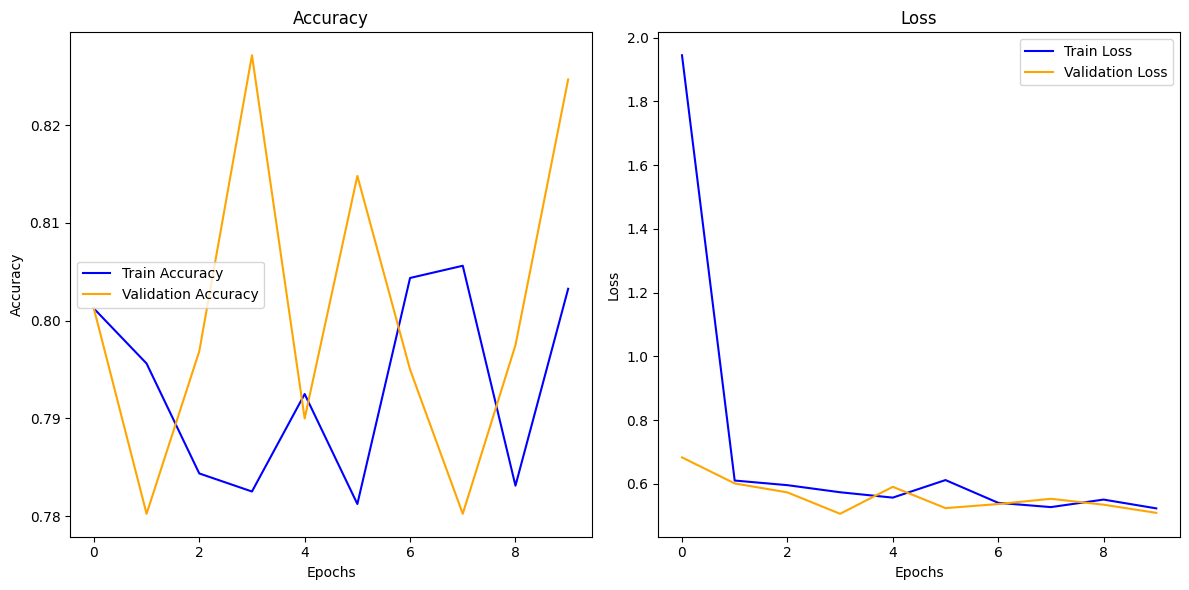

In [19]:
import matplotlib.pyplot as plt

# Plot the training and validation accuracy and loss
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


314/314 ━━━━━━━━━━━━━━━━━━━━ 937s 3s/step
Classification Report:
              precision    recall  f1-score   support

    test_set       0.00      0.00      0.00      2023
training_set       0.80      1.00      0.89      8005

    accuracy                           0.80     10028
   macro avg       0.40      0.50      0.44     10028
weighted avg       0.64      0.80      0.71     10028



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


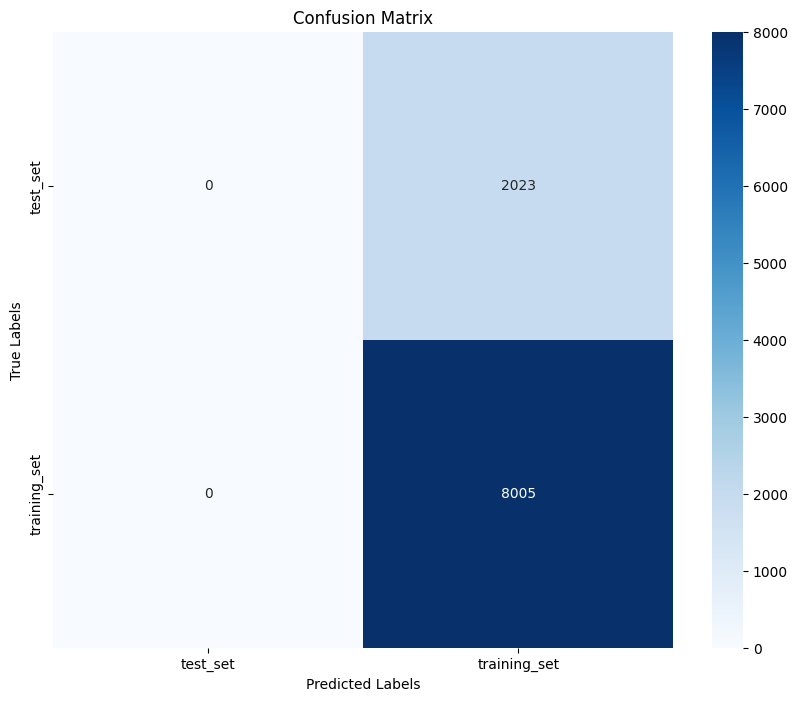

In [20]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Get true labels and predictions
true_labels = test_data.classes  # Actual labels from the test dataset
predictions = model.predict(test_data, steps=len(test_data))
predicted_classes = np.argmax(predictions, axis=1)  # Predicted classes

# Classification report
class_names = list(test_data.class_indices.keys())  # Class names
print("Classification Report:")
print(classification_report(true_labels, predicted_classes, target_names=class_names))

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
